In [1]:
library(tidyverse)
library(tidytext)
library(naivebayes)
library(tm)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
naivebayes 0.9.7 loaded

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


The following object is masked from ‘package:httr’:

    content


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




In [2]:
download.file(url = "https://raw.githubusercontent.com/jboscomendoza/rpubs/master/bayes_twitter/tuits_bayes.csv", destfile = "tuits.csv")

In [3]:
tuits_df <-read.csv("tuits.csv", stringsAsFactors = F, fileEncoding = "latin1") %>%
  tbl_df

Warning message:
“`tbl_df()` was deprecated in dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.”


**Procesamiento de los datos**
Vamos a definir una función para quitar URLs. En nuestros datos todos los URLs han sido acortados, por lo que dificilmente obtendremos información relevante de de ellos por ser series de caracteres sin mucho significado.

La función siguiente usa regexp para detectar palabras que empiecen con “http” y las eliminará.

In [4]:
quitar_url <- function(texto) {
    gsub("\\<http\\S*\\>|[0-9]", " ", texto)
}

**Creación de matriz dispersa**
Para clasificar texto usando Naïve Bayes necesitamos que nuestros datos tengan estructura específica:

Cada renglon debe corresponder a un texto específico.
Cada columna debe corresponder a una palabra.
En las celdas debe indicarse si una palabra aparece en un texto específico.


In [5]:
tuits_df

status_id,screen_name,text
<dbl>,<chr>,<chr>
8.324215e+17,lopezobrador_,Josefina Vázquez Mota debe informar qué hizo con los mil millones de pesos que le autorizó EPN. Basta de corrupción e hipocresía PRIANISTA.
8.331306e+17,lopezobrador_,Ya ni la burla perdonan: bajaron 2 centavos la gasolina. En Guatemala no hay petróleo y es más barata la gasolina que en México. Corruptos.
8.335013e+17,lopezobrador_,Martín Moreno no votará por mí. Comprendo. Es un mal escritor dedicado a explotar la ignorancia y el conservadurismo de la sociedad. Gracias
8.338952e+17,lopezobrador_,En Chicago dije que iremos a Nueva York (ONU) y a Washington (CIDH) el 14 y 15 de marzo a denunciar órdenes-Trump https://t.co/nTeKURAIzv
8.341838e+17,lopezobrador_,Entérate y apoya con tu firma la denuncia contra las órdenes de Donald Trump https://t.co/FEICSPQ4pn
8.345660e+17,lopezobrador_,"Qué república ni qué ocho cuartos, es la monarquía de la moronga azul. Corrupta e hipócrita. https://t.co/jYqIi4dFL8"
8.352975e+17,lopezobrador_,"Salieron a defender a Yunes Linares, Calderón, su esposa, Anaya, el del PRI y una cosa que se llama FEPADE, en fin, toda la maleantada."
8.359036e+17,lopezobrador_,"En 2010, la trasnacional Odebrecht entregó sobornos para operar una planta petroquímica en México. Debe investigarse a Calderón y socios."
8.364175e+17,lopezobrador_,"Calderón dice donará su sueldo como expresidente, es el 8% de lo que recibe de pensión. De 54.2 mdp costará mantenerlo 50.8 millones al año https://t.co/mg25pNGIgE"


Entonces para convertir nuestros datos a una matriz dispersa necesitamos:

Segmentar cada tuit por palabras.
Contar cuantas veces aparce cada palabra por tuit.
Dar formato de matriz “ancha”.
Lo anterior lo realizamos con las siguientes funciones:

unnest_tokens() del paquete tidytext. Segmentamos una variable por palabras, creando una nueva columna con ellas.
count() de dplyr. Ya que tenemos las palabras en una columna, contamos cuántas veces aparecen por tuit.
spread() de tidyr. Los pasos anteriores nos dejan con datos “altos”, pues tendremos tantos renglones como palabras, pero buscamos tener tantas columnas como palabras. Con esta función pasamos de un formato “alto” de datos a uno “ancho”.

In [6]:
tuits_df %>%
  unnest_tokens(input = "text", output = "palabra") %>%
  count(screen_name, status_id, palabra) %>%
  spread(key = palabra, value = n)

screen_name,status_id,_mx,_paolimeow,_siqure,00,03,04npkn59na,04p2fdlagz,08ij203qie,⋯,ztzpuo0zmr,zu1rqateru,zuuuuuukiiiiiitiiiiii,zw6fivgsy9,zwgzff7duv,zwhlxfsvfb,zwn5nrt3ac,zxa2oqdte9,zyvcectcsp,zzapvyhe2m
<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
__dianapatricia,9.834750e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
_vichoo1,9.834750e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
_victoriacetina,9.834751e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
09osuna,9.834751e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1javierespinoza,9.834750e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Accountant_Job,9.834750e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AcuarioJac,9.834750e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
agenciasanluis,9.834750e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Alexvaldesp,9.834750e+17,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Obenemos un objeto con 1348 renglones (uno por tuit) y 8 571 columnas (una por palabra en nuestros datos).

Este proceso lo realizaremos varias veces, así que nos conviene definir una función. De paso, aprovechamos para introducir en ella el proceso el quitar los URLs y la columna status_id, que no es necesaria para el resto del análisis.

In [7]:
crear_matriz <- function(tabla) {
  tabla %>%
    mutate(text = quitar_url(text)) %>%
    unnest_tokens(input = "text", output = "palabra") %>%
    count(screen_name, status_id, palabra) %>%
    spread(key = palabra, value = n) %>%
    select(-status_id)
}

**Ajustando Naive Bayes**
Crearemos un modelo de predicción para determinar si un tuit pertenece a un usuario específico. Para esta prueba, intentaremos predecir si un tuit fue hecho por la cuenta @MSFTMexico o no. Dado que no nos interesa a qué categoría pertenecen los demás tuits, etiquetaremos todos los tuits que no pertenecen a esta cuenta como “Otro”.

Aunque Naive Bayes puede hacer clasificaciones con múltiples categorías, conviene empezar con un ejemplo de clasificación binaria.

Recodificamos nuestra variable objetivo, screen_name, y creamos nuestra matriz dispersa con las funciones mutate() de dplyr e ifelse() de base. Aprovechamos para convertir nuestra variable objetivo a factor, que es el tipo de datos más compatible con la implementación de Naive Bayes que usaremos.

In [8]:
ejemplo_matriz <-
  tuits_df %>%
  mutate(screen_name = ifelse(screen_name == "MSFTMexico", screen_name, "Otro"),
         screen_name = as.factor(screen_name)) %>%
  crear_matriz

Como haremos varias clasificaciones más adelante, es definimos una función para realizar la recodificación fácilmente.

In [9]:
elegir_usuario <- function(nombres, usuario) {
  as.factor(ifelse(nombres %in% usuario, nombres, "Otro"))
}

Cuando creamos un modelo de clasificación necesitamos un diagnósito de qué tan bien está haciendo su trabajo. Para este fin dividiremos nuestros datos en dos sets (conjuntos), uno de entrenamiento (train) y uno de de prueba (test).

Con el set de entrenamiento ajustaremos nuestro modelo, en este caso, determinando las probabilidades condicionales de cada palabra, para cada categoría. Después, aplicamos este modelo en nuestro set de prueba para analizar cuántos de nuestros casos fueron clasificados correctamente.

Dividiremos nuestros datos de modo que tengamos 70% de ellos en el set de entrenamiento y el resto en el set de prueba. Usaremos la función sample_frac() de dplyr para obtener una muestra al azar de nuestros datos y despues setdiff() del mismo paquete para obtener su complemento. Para que el ejemplo sea reproducible, usaremos set.seed() de base antes de obtener el primer set.

In [10]:
set.seed(2001)
ejemplo_entrenamiento <- sample_frac(ejemplo_matriz, .7)
ejemplo_prueba <- setdiff(ejemplo_matriz, ejemplo_entrenamiento)

También definimos una función para crear sets de entrenamiento y prueba, que nos serán devueltos en forma de lista.

In [11]:
crear_sets <- function(tabla, prop = .7) {
  lista_sets <- list()
  lista_sets$train <- sample_frac(tabla, prop)
  lista_sets$test  <- setdiff(tabla, lista_sets[["train"]])

  lista_sets
}

**Usando la función naive_bayes**
Para ajustar nuestro modelo usamos la función naive_bayes() del paquete naivebayes con nuestro set de entrenamiento. Esta función nos pide como argumentos la variable objetivo para clasificar y los datos que serán usados.

Especificamos la variable objetivo como una formula: screen_name ~ .

De esta manera estamos expresando que la variable screen_name será el objetivo o variable dependiente, y todas las demás variables (.) serán los predictores o variables independientes. No ajustaremos ningún otro parámetro de la función naive_bayes() para este ejemplo.

In [12]:
ejemplo_modelo <- naive_bayes(formula = screen_name ~ .,  data = ejemplo_entrenamiento)

Esperamos un poco en lo que hace su trabajo ¡Y eso es todo! Con esto ya tenemos un objeto que contiene nuestro modelo de predicción de Naïve Bayes, el cual podemos usar para hacer predicciones.

Haciendo predicciones con nuestro modelo
Para hacer predicciones con nuestro modelo usamos la función predict() de base. Esta función nos pide un modelo y datos nuevos, que en nuestro caso son el set de prueba.

In [13]:
ejemplo_prediccion <- predict(ejemplo_modelo, ejemplo_prueba)

Warning message:
“predict.naive_bayes(): more features in the newdata are provided as there are probability tables in the object. Calculation is performed based on features to be found in the tables.”


Como resultado obtenemos un vector con los valores de screen_name que han sido predichos por nuestro modelo.

In [14]:
head(ejemplo_prediccion, 25)

[1] MSFTMexico MSFTMexico MSFTMexico MSFTMexico MSFTMexico MSFTMexico
 [7] MSFTMexico MSFTMexico Otro       MSFTMexico MSFTMexico MSFTMexico
[13] MSFTMexico MSFTMexico MSFTMexico MSFTMexico MSFTMexico MSFTMexico
[19] Otro       MSFTMexico MSFTMexico MSFTMexico MSFTMexico MSFTMexico
[25] MSFTMexico
Levels: MSFTMexico Otro

Para analizar qué tanto éxito hemos tenido, creamos una matriz de confusión usando la función confusionMatrix() de caret, que es muy similar en su sintaxis a table() de base. No pide dos argumentos, el vector con las predicciones y los valores reales de screen_name.

Con esta matriz podremos analizar la precisión de nuestras predicciones y algunas medidas de ajuste.

In [15]:
confusionMatrix(ejemplo_prediccion, ejemplo_prueba[["screen_name"]])

Confusion Matrix and Statistics

            Reference
Prediction   MSFTMexico Otro
  MSFTMexico         48   20
  Otro               11  309
                                          
               Accuracy : 0.9201          
                 95% CI : (0.8885, 0.9451)
    No Information Rate : 0.8479          
    P-Value [Acc > NIR] : 1.404e-05       
                                          
                  Kappa : 0.7084          
                                          
 Mcnemar's Test P-Value : 0.1508          
                                          
            Sensitivity : 0.8136          
            Specificity : 0.9392          
         Pos Pred Value : 0.7059          
         Neg Pred Value : 0.9656          
             Prevalence : 0.1521          
         Detection Rate : 0.1237          
   Detection Prevalence : 0.1753          
      Balanced Accuracy : 0.8764          
                                          
       'Positive' Class : MSFTMexico     

¡Excelente! 92% de precisión (Accuracy) no está nada mal para un modelo al que no hemos hecho ningún ajuste particular. Clasificamos correctamente cerca de nueve de cada diez casos.

Sin embargo, nos conviene dar un vistazo rápido a algunas de las medidas que nos ofrece confusionMatrix(), pues la medida de precisión por sí misma puede ser engañosa. Veamos con más detalle la información que nos da.

Interpretando la matriz de confusión
Primero, tenemos tabla de confusión, propiamente dicha. En ella lo primero que nos interesa observar son las celdas en las que se cruzan los valores predichos (MSFTMExico) contra los de referencia. Es decir, el número en la celda en las que cruza el renglón MSFTMexico y la columna MSFTMexico corresponde a la cantidad de casos clasificados correctamente en esa categoría.

De 53 casos que eran MSFTMexico en el set de prueba, clasificamos correctamente 40, es decir, tuvimos una Sensibilidad (Sensitivity) de 75.47%. De manera complementaria, de 335 casos que eran Otro, clasificamos correctamente 319, esto es, 95.22% de Especificidad (Specificity). En otras palabras, tuvimos más éxito clasificando a la categoría Otro que MSFTMexico.

Otra medida útil es el estadístico Kappa. Este nos da una medida de qué tanto mejora nuestro modelo una predicción, contra las probabilidades observadas.

Por ejemplo, supongamos que tenemos un conjunto de datos donde 50% de ellos pertenecen a la clase A y el otro 50% a la B. Esto quiere decir que, por azar, clasificaríamos correctamente 50% de los casos en nuestros datos como A, pues esta es su probabilidad esperada. Un modelo que tenga 50% de clasificaciones correctas, no estaría mejorando nuestra capacidad de predicción más allá del azar. Un modelo tendría que clasificar correctamente más del 50% de los casos para considerarse una mejora sobre la probabilidad esperada.

Entre más cercano a 1 es el valor de Kappa, nuestro modelo es mejor para predecir que la probabilidad esperada. Qué valor de Kappa consideremos ideal depende del contexto de nuestro análisis, pero en general, valores arriba de 0.6 se consideran “buenos”.

El valor predictivo positivo (Pos Pred Value) indica la probabilidad de que un dato que ha sido predicho como perteneciente a nuestra categoría “positiva”, realmente pertenezca a ella (‘Positive’ Class : MSFTMexico, en este ejemplo). En este caso, la probabilidad es de 71.43%. Por complemento, el valor predictivo negativo (Neg Pred Value) indica la probabilidad de que un dato predicho como perteneciente a la categoría negativa (“Otro”), en efecto pertenezca a ella. Esta fue de 96.08%.

Finalmente, la precisión balanceada, indica qué tan bien predice nuestro modelo tanto a la categoría positiva, como a la negativa. Esto es muy importante con datos como los nuestros, en los que tenemos clases no balanceadas, es decir, que una es más abundante y tiene más probabilidades de aparecer que la otra. En conjuntos de datos como estos, es fácil obtener una precisión alta para la clase más probable, aunque tengamos poca para la clase menos probable.

Nuestra precisión balanceada es de 85.35% lo cual no está mal, aunque podría mejorar.

**Resultados**
Considerando todo lo anterior, podemos concluir que tenemos una buena precisión en nuestras predicciones, con más éxito para clasificar “Otro” que “MSFTMExico” y que nuestro modelo en efecto mejora la predicción con respecto a la probabilidad esperada.

Pero aún no hemos terminado.

**Funciones para facilitar el análisis**
El paso anterior puede simplificarse, de modo que sea más fácil realizar análisis posteriores.

Para ello definimos una función para ajustar Naïve Bayes y obtener predicciones, a partir de un lista con datos de entrenamiento y de prueba. Esta función nos devolvera una lista con el modelo y sus predicción.

In [16]:
obtener_bayes <- function(lista_sets, objetivo = "screen_name") {
  bayes_formula<- as.formula(paste0(objetivo, "~ .") )
  bayes <- list()

  bayes$modelo <- naive_bayes(formula = bayes_formula, data = lista_sets[["train"]])
  bayes$prediccion   <- predict(object = bayes$modelo, newdata = lista_sets[["test"]])

  bayes
}

También definimos una función para obtener matrices de confusión, a partir de la lista que devuelve la función anterior.

In [17]:
mat_conf <- function(resultado, set_test) {
  confusionMatrix(resultado[["prediccion"]], set_test[["test"]][["screen_name"]])
}

También ws posible crear gráficas a partir de las matrices de confusión, usando el elemento table que devuelve la función confusionMatrix.

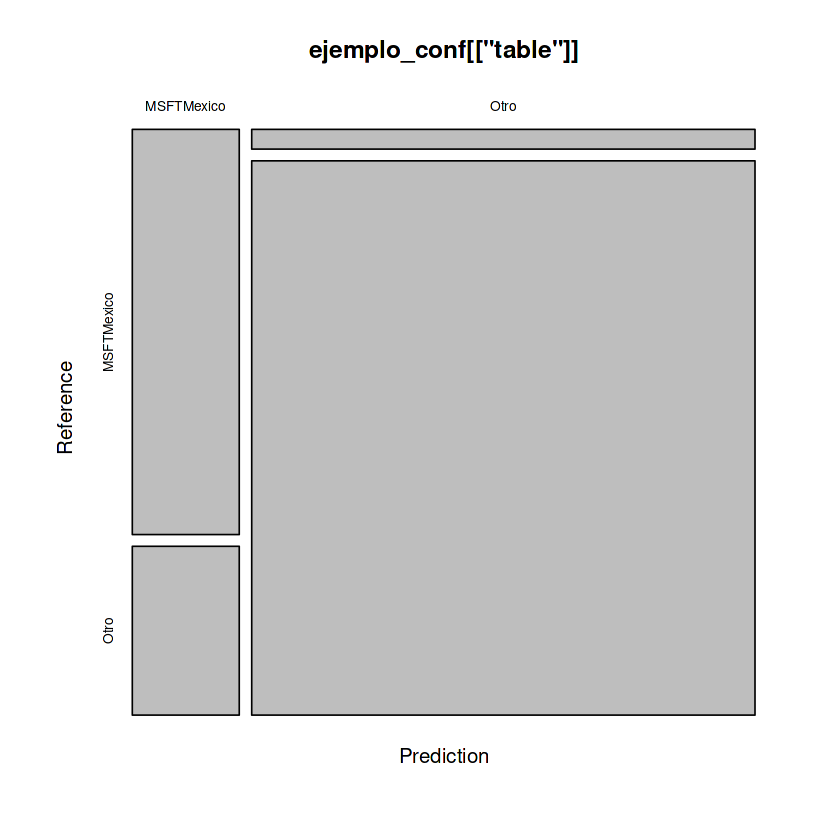

In [18]:
ejemplo_conf <- confusionMatrix(ejemplo_prediccion, ejemplo_prueba[["screen_name"]])
plot(ejemplo_conf[["table"]])

Así que taambien definimos una función para graficar matrices de confusión a partir de la lista de resultados que nos devuelve la función obtener_bayes.

In [19]:
plot_conf <- function(resultados_bayes) {
  plot(resultados_bayes[["confusion"]][["table"]],
       col = c("#00BBFF", "#FF6A00"),
       main = resultados_bayes[["confusion"]][["positive"]])
}

Sistematizando nuestro análisis
Integrando los pasos anteriores y las funciones que hemos definido para realizarlos, podemos definir una función para implementar Naïve Bayes.

In [20]:
hacer_bayes <- function(tabla, usuario) {
  ingenuo <- list()

  ingenuo[["matriz"]] <-tabla %>%mutate(screen_name = elegir_usuario(screen_name, usuario)) %>%crear_matriz()

  ingenuo[["sets"]] <- crear_sets(ingenuo[["matriz"]])

  ingenuo[["resultado"]] <- obtener_bayes(ingenuo[["sets"]])

  ingenuo[["confusion"]] <- list()

  ingenuo[["confusion"]] <- mat_conf(ingenuo[["resultado"]], ingenuo[["sets"]])

  ingenuo
}

veamos como funcionaría nuestra función. Intentaremos clasificar los tuits de la cuenta @CMLL_OFICIAL. Una vez más usamos set.seed() para hacer reproducible este ejemplo.

In [21]:
set.seed(1988)
bayes_cmll <- hacer_bayes(tuits_df, "CMLL_OFICIAL")

Warning message:
“predict.naive_bayes(): more features in the newdata are provided as there are probability tables in the object. Calculation is performed based on features to be found in the tables.”


De lo anterior obtenemos una lista con:

Un data frame con la matriz dispersa.

In [22]:
bayes_cmll[["mat"]]

NULL

Una lista con los sets de entrenamiento y prueba.

In [23]:
bayes_cmll[["sets"]][["train"]]

screen_name,_mx,_paolimeow,_siqure,a,abajo,abastecimiento,abiertas,abiertos,abogado,⋯,zea,zed,zeuxis,zihuatanejo,zona,zonas,zopilotada,zopilotes,zorra,zuuuuuukiiiiiitiiiiii
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Otro,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Otro,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Otro,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Otro,NA,NA,NA,1,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Otro,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Otro,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Otro,NA,NA,NA,2,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Otro,NA,NA,NA,1,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [24]:
bayes_cmll[["sets"]][["test"]]

screen_name,_mx,_paolimeow,_siqure,a,abajo,abastecimiento,abiertas,abiertos,abogado,⋯,zea,zed,zeuxis,zihuatanejo,zona,zonas,zopilotada,zopilotes,zorra,zuuuuuukiiiiiitiiiiii
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CMLL_OFICIAL,NA,NA,NA,2,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,2,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,1,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,1,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,1,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,1,NA,NA,NA,NA,NA,⋯,NA,NA,1,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,1,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CMLL_OFICIAL,NA,NA,NA,1,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Una lista con los resultados de Naïve Bayes: modelo y predicciones.

In [25]:
bayes_cmll[["resultado"]][["modelo"]]


================================== Naive Bayes ================================== 
 
 Call: 
naive_bayes.formula(formula = bayes_formula, data = lista_sets[["train"]])

--------------------------------------------------------------------------------- 
 
Laplace smoothing: 0

--------------------------------------------------------------------------------- 
 
 A priori probabilities: 

CMLL_OFICIAL         Otro 
   0.1311828    0.8688172 

--------------------------------------------------------------------------------- 
 
 Tables: 

--------------------------------------------------------------------------------- 
 ::: _mx (Gaussian) 
--------------------------------------------------------------------------------- 
      
_mx    CMLL_OFICIAL Otro
  mean                 1
  sd                    

--------------------------------------------------------------------------------- 
 ::: _paolimeow (Gaussian) 
-------------------------------------------------------------------------------

In [26]:
head(bayes_cmll[["resultado"]][["prediccion"]], 25)

[1] CMLL_OFICIAL Otro         Otro         CMLL_OFICIAL CMLL_OFICIAL
 [6] Otro         CMLL_OFICIAL CMLL_OFICIAL CMLL_OFICIAL CMLL_OFICIAL
[11] CMLL_OFICIAL Otro         CMLL_OFICIAL CMLL_OFICIAL CMLL_OFICIAL
[16] CMLL_OFICIAL CMLL_OFICIAL Otro         Otro         CMLL_OFICIAL
[21] Otro         Otro         Otro         CMLL_OFICIAL CMLL_OFICIAL
Levels: CMLL_OFICIAL Otro

Una matriz de confusión

In [27]:
bayes_cmll[["confusion"]]

Confusion Matrix and Statistics

              Reference
Prediction     CMLL_OFICIAL Otro
  CMLL_OFICIAL           25    7
  Otro                    9  349
                                          
               Accuracy : 0.959           
                 95% CI : (0.9342, 0.9764)
    No Information Rate : 0.9128          
    P-Value [Acc > NIR] : 0.0002974       
                                          
                  Kappa : 0.7352          
                                          
 Mcnemar's Test P-Value : 0.8025873       
                                          
            Sensitivity : 0.73529         
            Specificity : 0.98034         
         Pos Pred Value : 0.78125         
         Neg Pred Value : 0.97486         
             Prevalence : 0.08718         
         Detection Rate : 0.06410         
   Detection Prevalence : 0.08205         
      Balanced Accuracy : 0.85782         
                                          
       'Positive' Class : C

Finalmente, si así lo deseamos, podemos simplificar aún más nuestro código con la función map() del paquete purrr, que aprovecha las capacidades de programación funcional de R. De este modo podemos hacer múltiples análisis con una sóla línea de código.

Para ello creamos una lista con todos los nombres de usuario que nos interesan y después le aplicamos nuestra función hacer_bayes() con map.

In [ ]:
lista_usuarios <- list(lopezobrador_ = "lopezobrador_",MSFTMexico = "MSFTMexico",UNAM_MX  = "UNAM_MX",CMLL_OFICIAL = "CMLL_OFICIAL")

lista_bayes <- map(lista_usuarios, hacer_bayes, tabla = tuits_df)

lista_bayes

Warning message:
“predict.naive_bayes(): more features in the newdata are provided as there are probability tables in the object. Calculation is performed based on features to be found in the tables.”
